In [1]:
import qiskit as qk
from qiskit_aer.primitives import Sampler 
import numpy as np
import fractions
import contfrac

# Теоретичні відомості
**Задача факторизації числа** - для заданого числа $n$ знайти один з його нетривіальних дільників (тобто число $1 < d < n$ таке, що $d \mid n$).
Ми швидко можемо знайти нетривіальний дільник якщо число є:
- Парним
- Простим
- Степінем простого числа

Тому, без втрати загальності вважаємо що число $n$ непарне і має не менше двох простих дільників.

## Задача пошуку періоду періодичної функції
Неохідно знайти значення $s \in \mathbb Z_N \setminus \{0\}$ таке, що для заданої періодичної функції $f: \mathbb Z_N \to X, 1 < N \in \mathbb N$ для довільного $x \in \mathbb N$ виконується $f(x + s) = f(x)$. 

## Алгоритм Шора
Алгоритм Шора показує як за поліноміальну кількість кроків з високою ймовірністю отримати значення періоду функції.
<p align="center"><img src="Images\shor_circuit.png"></img></p>
<p align="center">Квантова схема алгоритму Шора</p>

Алгоритм вимагає побудови піднесення до степіня за модулем. Завдання має на меті знати відомий розклад числа $15$ на два множники: $3, 5$.


Тому, першим кроком у побудові алгоритму Шора є створення відповідних схем для піднесення до степіня.

# Схеми піднесення до степіня за модулем $15$
(_Усі схеми взяті зі статті_ https://arxiv.org/pdf/1202.6614)


Замість самого числа $15$ сучасна версія алгориму Шора використовує степінь двійки, яка знаходиться з умов
$$
N^2 < 2^q \le 2N^2
$$
де, в нашому випадку, $N= 15$; можна переконатись, що $q = 8$.

Таким чином, перший регістр містить 8 кубітів, а другий - 4.

## Допомінжні функції
Спрешу, напишемо декілька допоміжних фукнцій, щоб полегшити собі роботу.

In [2]:
# Декоратор, що перетворює функцію, яка повертає квантову схему, на функцію, що поверає виміряне число.
def run_circuit(circuit_function):
    def wrapper(*args, **kwargs):
        circuit = circuit_function(*args, **kwargs)
        sampler = Sampler()
        job = sampler.run(circuits=[circuit], num_shots=1)
        return list(job.result().quasi_dists[0].keys())[0] # Просто повертає виміряне число
    return wrapper

# Функція, для обрахунку степені за модулем з використанням заданої схеми "pow_circuit"
@run_circuit
def pow_test(x, pow_circuit):
    # Попередня обробка вхідних данних (не потрібно в квантовій схемі)
    if x < 2: x = "0%s" % x
    else: x = bin(x)[-2:]
    num, output, result = qk.QuantumRegister(8, name="x"), qk.QuantumRegister(4, name="y"), qk.ClassicalRegister(4, name="res")
    circuit = qk.QuantumCircuit(num, output, result)
    circuit.initialize(x, num[-2:])
    circuit.append(pow_circuit, num[:] + output[:])
    circuit.measure(output, result)
    return circuit

# Функція для перевірки відповідності значень
def check(num, pow_circuit):
    for i in range(1, 5): 
        print("Очікуваний результат %s\tКвантова схема %s" % (pow(num, i, 15), pow_test(i, pow_circuit)))

## Схема $f(x) = 2^x (\text{mod } 15)$
Нище наведено схему для піднесення числа $2$ до степіня $x$ за модулем $15$ та її відповідну програмну реалізацію.
<p align="center"><img src="Images\pow2.png"></img></p>
<p align="center">Схема піднесення числа 2 за модулем 15</p>

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


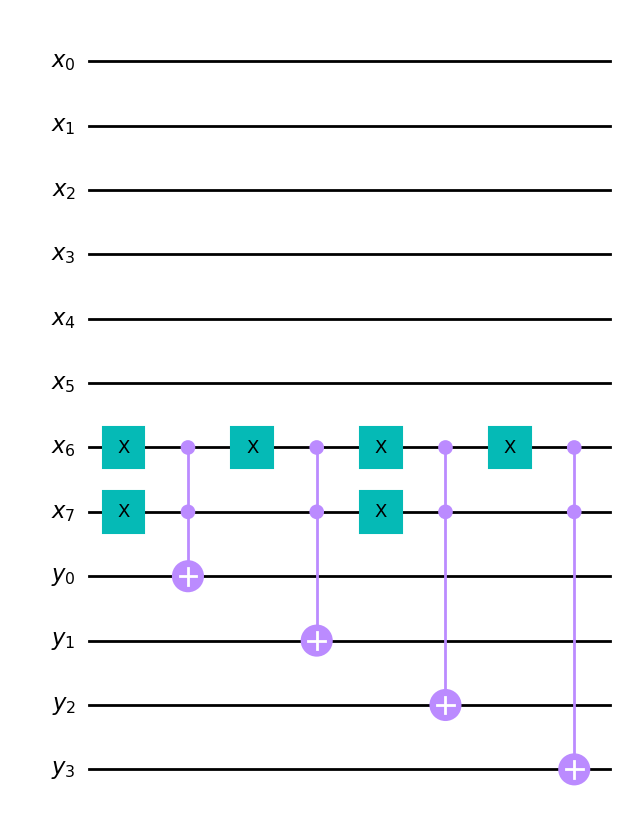

In [3]:
num, output = qk.QuantumRegister(8, name="x"), qk.QuantumRegister(4, name="y")
pow2 = qk.QuantumCircuit(num, output, name=r"$2^x(\text{mod } 15)$")
pow2.x(num[-2:])
pow2.ccx(*num[-2:], output[0])
pow2.x(num[-2])
pow2.ccx(*num[-2:], output[1])
pow2.x(num[-2:])
pow2.ccx(*num[-2:], output[2])
pow2.x(num[-2])
pow2.ccx(*num[-2:], output[3])
pow2.draw(output="mpl")

### Перевірка роботи

In [4]:
check(2, pow2)

Очікуваний результат 2	Квантова схема 2
Очікуваний результат 4	Квантова схема 4
Очікуваний результат 8	Квантова схема 8
Очікуваний результат 1	Квантова схема 1


Як бачимо, схема дісно викновує піднесення числа $2$ за модулем $15$.

## Схема $4^x (\text{mod }15)$
Схема має дуже простий вигляд (для економії одного вентиля $X$ порядок застосування вентилів Тоффолі змінено)
<p align="center"><img src="Images\pow4.png"></img></p>
<p align="center">Схема піднесення числа 4 за модулем 15</p>

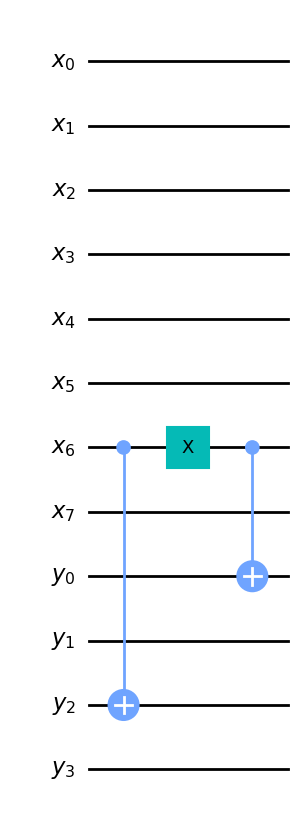

In [5]:
num, output = qk.QuantumRegister(8, name="x"), qk.QuantumRegister(4, name="y")
pow4 = qk.QuantumCircuit(num, output, name=r"$4^x(\text{mod } 15)$")
pow4.cx(num[-2], output[2])
pow4.x(num[-2])
pow4.cx(num[-2], output[0])
pow4.draw(output="mpl")

### Перевірка

In [6]:
check(4, pow4)

Очікуваний результат 4	Квантова схема 4
Очікуваний результат 1	Квантова схема 1
Очікуваний результат 4	Квантова схема 4
Очікуваний результат 1	Квантова схема 1


## Схема $7^x(\text{mod }15)$
Тепер реалізуємо схему для піднесення числа $7$ (знову, порядок трохи змінено)
<p align="center"><img src="Images\pow7.png"></img></p>
<p align="center">Схема піднесення числа 7 за модулем 15</p>

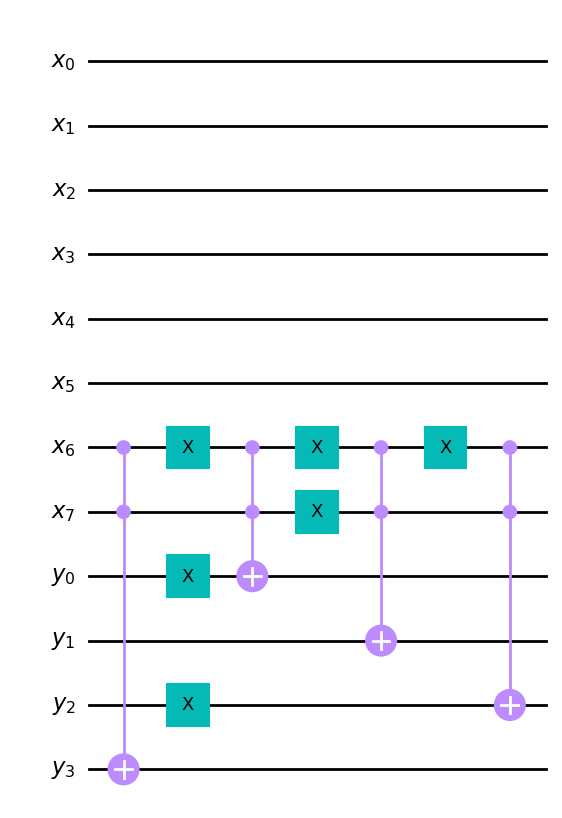

In [7]:
num, output = qk.QuantumRegister(8, name="x"), qk.QuantumRegister(4, name="y")
pow7 = qk.QuantumCircuit(num, output, name=r"$7^x(\text{mod } 15)$")
pow7.ccx(*num[-2:], output[3])
pow7.x([num[-2], output[0], output[2]])
pow7.ccx(*num[-2:], output[0])
pow7.x(num[-2:])
pow7.ccx(*num[-2:], output[1])
pow7.x(num[-2])
pow7.ccx(*num[-2:], output[2])

pow7.draw(output="mpl")

### Перевірка

In [8]:
check(7, pow7)

Очікуваний результат 7	Квантова схема 7
Очікуваний результат 4	Квантова схема 4
Очікуваний результат 13	Квантова схема 13
Очікуваний результат 1	Квантова схема 1


## Схема $f(x) = 8^x(\text{mod }15)$
Наступною буде схема для піднесення числа 8.
<p align="center"><img src="Images\pow8.png"></img></p>
<p align="center">Схема піднесення числа 8 за модулем 15</p>

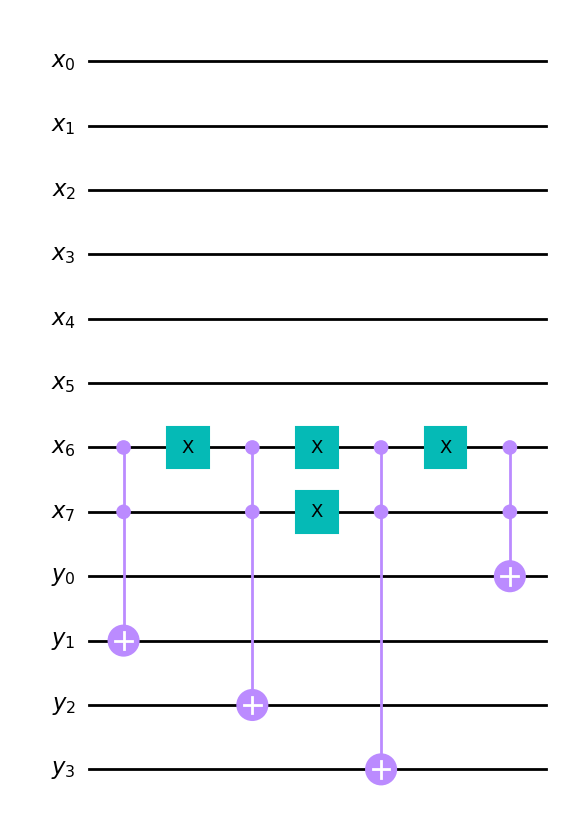

In [9]:
num, output = qk.QuantumRegister(8, name="x"), qk.QuantumRegister(4, name="y")
pow8 = qk.QuantumCircuit(num, output, name=r"$8^x(\text{mod } 15)$")
pow8.ccx(*num[-2:], output[1])
pow8.x(num[-2])
pow8.ccx(*num[-2:], output[2])
pow8.x(num[-2:])
pow8.ccx(*num[-2:], output[3])
pow8.x(num[-2])
pow8.ccx(*num[-2:], output[0])
pow8.draw(output="mpl")

### Перевірка

In [10]:
check(8, pow8)

Очікуваний результат 8	Квантова схема 8
Очікуваний результат 4	Квантова схема 4
Очікуваний результат 2	Квантова схема 2
Очікуваний результат 1	Квантова схема 1


## Схема $f(x) = 11^x(\text{mod }15)$
Переходимо до схеми для піднесення числа $11$ до степені за модулем $15$.
<p align="center"><img src="Images\pow11.png"></img></p>
<p align="center">Схема піднесення числа 11 за модулем 15</p>

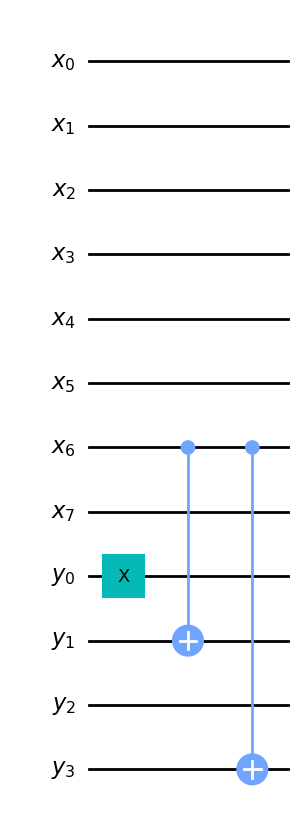

In [11]:
num, output = qk.QuantumRegister(8, name="x"), qk.QuantumRegister(4, name="y")
pow11 = qk.QuantumCircuit(num, output, name=r"$11^x(\text{mod } 15)$")
pow11.x(output[0])
pow11.cx(num[-2], output[1])
pow11.cx(num[-2], output[3])
pow11.draw(output="mpl")

### Перевірка

In [12]:
check(11, pow11)

Очікуваний результат 11	Квантова схема 11
Очікуваний результат 1	Квантова схема 1
Очікуваний результат 11	Квантова схема 11
Очікуваний результат 1	Квантова схема 1


## Схема $f(x) = 13^x (\text{mod }15)$
Передостання схема
<p align="center"><img src="Images\pow13.png"></img></p>
<p align="center">Схема піднесення числа 13 за модулем 15</p>

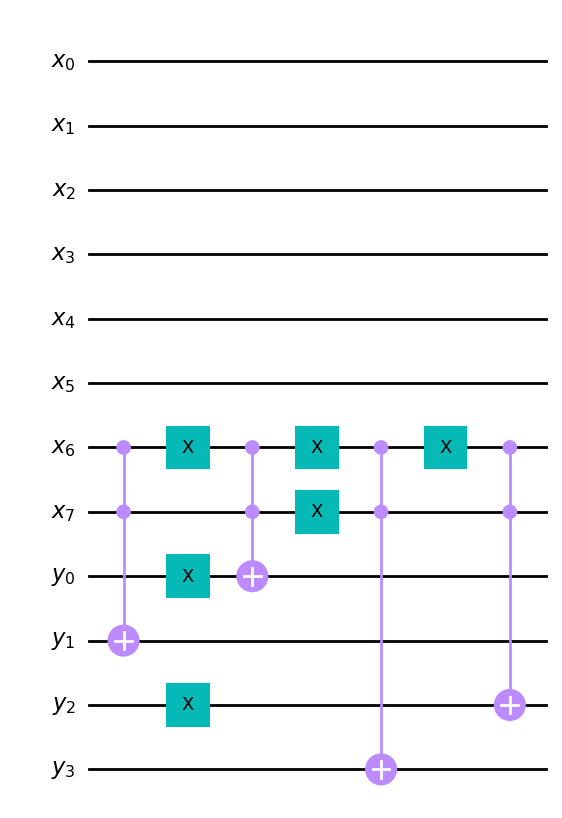

In [13]:
num, output = qk.QuantumRegister(8, name="x"), qk.QuantumRegister(4, name="y")
pow13 = qk.QuantumCircuit(num, output, name=r"$13^x(\text{mod } 15)$")
pow13.ccx(*num[-2:], output[1])
pow13.x([num[-2], output[0], output[2]])
pow13.ccx(*num[-2:], output[0])
pow13.x(num[-2:])
pow13.ccx(*num[-2:], output[3])
pow13.x(num[-2])
pow13.ccx(*num[-2:], output[2])

pow13.draw(output="mpl")

### Перевірка

In [14]:
check(13, pow13)

Очікуваний результат 13	Квантова схема 13
Очікуваний результат 4	Квантова схема 4
Очікуваний результат 7	Квантова схема 7
Очікуваний результат 1	Квантова схема 1


## Схема $f(x) = 14^x(\text{mod }15)$
Остання схема
<p align="center"><img src="Images\pow14.png"></img></p>
<p align="center">Схема піднесення числа 14 за модулем 15</p>

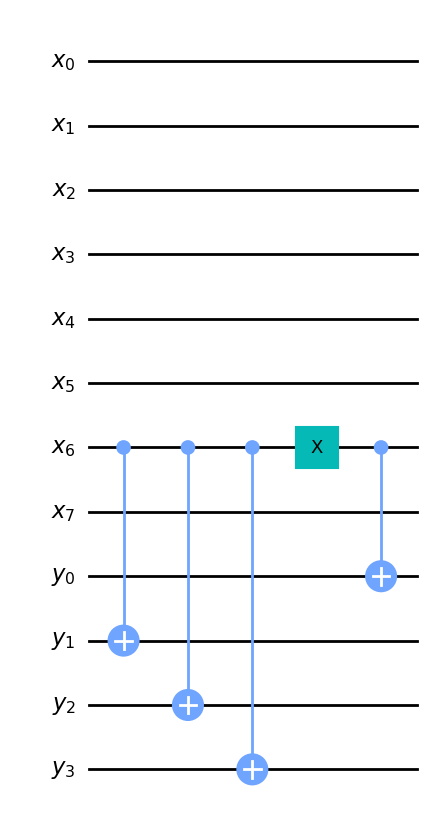

In [15]:
num, output = qk.QuantumRegister(8, name="x"), qk.QuantumRegister(4, name="y")
pow14 = qk.QuantumCircuit(num, output, name=r"$14^x(\text{mod } 15)$")
pow14.cx([num[-2]] * 3, output[1:])
pow14.x(num[-2])
pow14.cx(num[-2], output[0])
pow14.draw(output="mpl")

### Перевірка

In [16]:
check(14, pow14)

Очікуваний результат 14	Квантова схема 14
Очікуваний результат 1	Квантова схема 1
Очікуваний результат 14	Квантова схема 14
Очікуваний результат 1	Квантова схема 1


# Алгоритм Шора
Тепер перейдем до реалізації алгоритму Шора.
Традиційно, спочатку визначимо декілька корисних змінних

In [17]:
pows = {2 : pow2, 4 : pow4, 7 : pow7, 8 : pow8, 11 : pow11, 13 : pow13, 14 : pow14} # Відображення число -> алгоритм піднесення числа до степіня
QFTI = qk.circuit.library.QFT(8, name=r"$\text{QFT}^{-1}_{2^q}$").inverse() # Обернене перетворення Фур'є

Тепер, напишемо схему для алгоритму Шора.

In [18]:
@run_circuit
def shor_circuit(x):
    global pows, QFTI
    pow_circuit = pows[x]

    num, helper = qk.QuantumRegister(8, name="x"), qk.QuantumRegister(4, name="y")
    first_measure, second_measure = qk.ClassicalRegister(8, name="first"), qk.ClassicalRegister(4, name="second")
    circuit = qk.QuantumCircuit(num, helper, first_measure, second_measure)
    circuit.h(num)
    circuit.append(pow_circuit, num[:] + helper[:])
    circuit.append(QFTI, num)
    circuit.barrier()
    circuit.measure(num, first_measure) # Вимірюємо тільки перший регістр, тобто число з Z_Q
    return circuit

<p align="center"><img src="Images\shor_example_13.png"></img></p>
<p align="center">Приклад схеми квантового алгоритму Шора, при N = 13</p>

Залишилось написати сам алгоритм пошуку нетрвивіального дільника числа 15.

In [223]:
def factorization(num_iter):
    guesses = set()
    i = 0
    random_number = np.random.randint(2, 15) # Обираємо випадкове взаємо просте з 15 число з відрізка [2, 14]
    while np.gcd(random_number, 15) != 1: # Нічого не робимо, якщо одразу знайши нетривіальний дільник, для первірки квантової частини
         random_number = np.random.randint(2, 15)
         
    while i < num_iter:
        measured_number = shor_circuit(random_number) # Застосовуємо алгоритм Шора для пошуку періода
        convergents = contfrac.convergents(fractions.Fraction(measured_number, 256)) # Утворюємо послідовінсть підходящих дробів

        for _, denom in convergents: # Проходимось по знаменникам дробів, меньших за 15
            if denom >= 15: 
                break
            elif pow(random_number, denom, 15) == 1: # Додаємо "кандидата" в порядок
                guesses.add(denom)
        i += 1

    try:
        order = np.gcd.reduce(guesses).pop()
        if order % 2 == 0:
            return np.gcd(pow(random_number, order // 2) + 1, 15)
    except:
        return

In [224]:
for _ in range(5): print(factorization(20))

5
5
5
5
5


Як бачимо, алгоритм дійсно знаходить дільники.